In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout,LSTM

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Raw_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/only data/raw_data.npz'

Theta_data = '/content/drive/MyDrive/EEG Signal /Epileptic seizure/data/DWT/Raw/Alpha_DWT.npz'



# RAW = np.load(Raw_data, allow_pickle=True)  # Allow loading pickled object arrays
# X = RAW['X'].astype('float64')
# Y = RAW['Y'].astype('float64')
# group = RAW['Group'].astype('float64')

This is a good performing model

# CNN-LSTM

In [7]:
%%capture
!pip install tensorflow_addons

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN_LSTM/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN_LSTM/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
global_model, metrics_df = federated_learning(Theta_data)


Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 19s 64ms/step - loss: 1.7681 - accuracy: 0.5057 - val_loss: 1.7093 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 1.6586 - accuracy: 0.4984 - val_loss: 1.6053 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 17ms/step - loss: 1.5593 - accuracy: 0.4978 - val_loss: 1.5111 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 1.4693 - accuracy: 0.5038 - val_loss: 1.4258 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 17ms/step - loss: 1.3878 - accuracy: 0.4879 - val_loss: 1.3484 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 1.3140 - accuracy: 0.4906 - val_loss: 1.2784 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 18ms/step - loss: 1.2474 - accuracy: 0.4968 - val_loss: 1.2154 - val_accuracy: 0.4849
Epoch 8/100
29/29

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 100ms/step - loss: 1.7702 - accuracy: 0.4969 - val_loss: 1.7109 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 20ms/step - loss: 1.6606 - accuracy: 0.4952 - val_loss: 1.6066 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 21ms/step - loss: 1.5611 - accuracy: 0.5017 - val_loss: 1.5124 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 1.4713 - accuracy: 0.5006 - val_loss: 1.4273 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 21ms/step - loss: 1.3904 - accuracy: 0.4892 - val_loss: 1.3506 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 1.3173 - accuracy: 0.5028 - val_loss: 1.2817 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 35ms/step - loss: 1.2516 - accuracy: 0.5011 - val_loss: 1.2194 - val_accuracy: 0.4955
Epoch 8/100
28/28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 9s 76ms/step - loss: 1.7675 - accuracy: 0.4922 - val_loss: 1.7045 - val_accuracy: 0.5145
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 1.6528 - accuracy: 0.4894 - val_loss: 1.5961 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 1.5493 - accuracy: 0.4928 - val_loss: 1.4984 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 1.4564 - accuracy: 0.4987 - val_loss: 1.4107 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 1.3730 - accuracy: 0.4902 - val_loss: 1.3318 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 1.2980 - accuracy: 0.4943 - val_loss: 1.2611 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 1.2305 - accuracy: 0.5036 - val_loss: 1.1976 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 76ms/step - loss: 0.6848 - accuracy: 0.5687 - val_loss: 0.6964 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6699 - accuracy: 0.5946 - val_loss: 0.6972 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.6768 - accuracy: 0.5814 - val_loss: 0.6965 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.6689 - accuracy: 0.5959 - val_loss: 0.6969 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6560 - accuracy: 0.6202 - val_loss: 0.6976 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.6610 - accuracy: 0.5964 - val_loss: 0.6982 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 17ms/step - loss: 0.6533 - accuracy: 0.6175 - val_loss: 0.7000 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 81ms/step - loss: 0.6841 - accuracy: 0.5741 - val_loss: 0.6960 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 34ms/step - loss: 0.6715 - accuracy: 0.5988 - val_loss: 0.6961 - val_accuracy: 0.4966
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6705 - accuracy: 0.5976 - val_loss: 0.6963 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6644 - accuracy: 0.6121 - val_loss: 0.6966 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6570 - accuracy: 0.6234 - val_loss: 0.6969 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6508 - accuracy: 0.6313 - val_loss: 0.6964 - val_accuracy: 0.4966
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6488 - accuracy: 0.6276 - val_loss: 0.6964 - val_accuracy: 0.4955
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 59ms/step - loss: 0.6914 - accuracy: 0.5519 - val_loss: 0.6957 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6864 - accuracy: 0.5584 - val_loss: 0.6960 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6794 - accuracy: 0.5793 - val_loss: 0.6960 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6781 - accuracy: 0.5703 - val_loss: 0.6960 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 0.6735 - accuracy: 0.5832 - val_loss: 0.6960 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.6702 - accuracy: 0.5984 - val_loss: 0.6966 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6681 - accuracy: 0.5912 - val_loss: 0.6971 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 60ms/step - loss: 0.3869 - accuracy: 0.8376 - val_loss: 0.7699 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.2464 - accuracy: 0.9003 - val_loss: 0.8199 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 0.1834 - accuracy: 0.9286 - val_loss: 0.8648 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 17ms/step - loss: 0.1778 - accuracy: 0.9294 - val_loss: 0.9136 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 17ms/step - loss: 0.1242 - accuracy: 0.9534 - val_loss: 1.0626 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 17ms/step - loss: 0.1349 - accuracy: 0.9467 - val_loss: 1.1970 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 18ms/step - loss: 0.1409 - accuracy: 0.9467 - val_loss: 1.1302 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 65ms/step - loss: 0.3706 - accuracy: 0.8410 - val_loss: 0.7613 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.2715 - accuracy: 0.8933 - val_loss: 0.8003 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.2046 - accuracy: 0.9145 - val_loss: 0.8448 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.1804 - accuracy: 0.9310 - val_loss: 0.9182 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 0.1770 - accuracy: 0.9318 - val_loss: 0.9687 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 0.1271 - accuracy: 0.9539 - val_loss: 1.1172 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 22ms/step - loss: 0.1073 - accuracy: 0.9612 - val_loss: 1.2495 - val_accuracy: 0.4955
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 72ms/step - loss: 0.3920 - accuracy: 0.8251 - val_loss: 0.7513 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.2616 - accuracy: 0.8946 - val_loss: 0.8129 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.2242 - accuracy: 0.9111 - val_loss: 0.8508 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 22ms/step - loss: 0.1919 - accuracy: 0.9199 - val_loss: 0.9401 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1788 - accuracy: 0.9245 - val_loss: 1.0348 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.1851 - accuracy: 0.9256 - val_loss: 1.1331 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 0.1467 - accuracy: 0.9447 - val_loss: 1.3398 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 62ms/step - loss: 0.1336 - accuracy: 0.9580 - val_loss: 0.8668 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 17ms/step - loss: 0.0712 - accuracy: 0.9752 - val_loss: 1.0190 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0568 - accuracy: 0.9817 - val_loss: 1.0965 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 17ms/step - loss: 0.0774 - accuracy: 0.9709 - val_loss: 1.0707 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0751 - accuracy: 0.9723 - val_loss: 1.2203 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 17ms/step - loss: 0.0460 - accuracy: 0.9857 - val_loss: 1.4414 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0339 - accuracy: 0.9890 - val_loss: 1.7011 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 92ms/step - loss: 0.1164 - accuracy: 0.9666 - val_loss: 0.8513 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0813 - accuracy: 0.9743 - val_loss: 0.9943 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0536 - accuracy: 0.9822 - val_loss: 1.0568 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0622 - accuracy: 0.9808 - val_loss: 1.1701 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0703 - accuracy: 0.9771 - val_loss: 1.3129 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0616 - accuracy: 0.9808 - val_loss: 1.3355 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0455 - accuracy: 0.9853 - val_loss: 1.6721 - val_accuracy: 0.4955
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 65ms/step - loss: 0.1312 - accuracy: 0.9506 - val_loss: 0.8820 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0812 - accuracy: 0.9731 - val_loss: 1.0027 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0757 - accuracy: 0.9734 - val_loss: 1.0548 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0633 - accuracy: 0.9762 - val_loss: 1.1635 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0448 - accuracy: 0.9858 - val_loss: 1.4931 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0680 - accuracy: 0.9780 - val_loss: 1.4685 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 0.1098 - accuracy: 0.9618 - val_loss: 1.4269 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 64ms/step - loss: 0.0778 - accuracy: 0.9779 - val_loss: 1.0348 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0385 - accuracy: 0.9881 - val_loss: 1.2852 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0279 - accuracy: 0.9935 - val_loss: 1.3976 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.0402 - accuracy: 0.9871 - val_loss: 1.4598 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.0432 - accuracy: 0.9855 - val_loss: 1.5880 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 21ms/step - loss: 0.0347 - accuracy: 0.9895 - val_loss: 1.6175 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 22ms/step - loss: 0.0369 - accuracy: 0.9865 - val_loss: 1.8336 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 81ms/step - loss: 0.0771 - accuracy: 0.9737 - val_loss: 0.9939 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0422 - accuracy: 0.9856 - val_loss: 1.3494 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 22ms/step - loss: 0.0448 - accuracy: 0.9864 - val_loss: 1.2918 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 25ms/step - loss: 0.0389 - accuracy: 0.9884 - val_loss: 1.3871 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 23ms/step - loss: 0.0195 - accuracy: 0.9946 - val_loss: 1.8510 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.0377 - accuracy: 0.9892 - val_loss: 1.8455 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 20ms/step - loss: 0.0396 - accuracy: 0.9870 - val_loss: 1.8670 - val_accuracy: 0.4955
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 57ms/step - loss: 0.0936 - accuracy: 0.9687 - val_loss: 0.9925 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 1.2870 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0431 - accuracy: 0.9863 - val_loss: 1.5374 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0513 - accuracy: 0.9819 - val_loss: 1.4942 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0448 - accuracy: 0.9848 - val_loss: 1.6489 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0443 - accuracy: 0.9863 - val_loss: 1.8212 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0398 - accuracy: 0.9884 - val_loss: 1.7925 - val_accuracy: 0.4855
Epoch 8/100
31/31 

In [10]:

metrics_df.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.533,0.545,0.397,0.459,0.397,0.668,0.065
1,1,0.556,0.557,0.547,0.552,0.547,0.565,0.112
2,2,0.581,0.647,0.357,0.461,0.357,0.805,0.163
3,0,0.581,0.587,0.549,0.567,0.549,0.613,0.162
4,1,0.559,0.557,0.575,0.566,0.575,0.542,0.117
5,2,0.592,0.615,0.494,0.548,0.494,0.691,0.185
6,0,0.651,0.656,0.633,0.645,0.633,0.668,0.302
7,1,0.658,0.649,0.691,0.669,0.691,0.626,0.316
8,2,0.699,0.688,0.729,0.708,0.729,0.669,0.398
9,0,0.748,0.762,0.720,0.741,0.720,0.776,0.496


In [11]:
metrics_df.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN_LSTM/Alpha_DWT_CNN_LSTM.csv', index = False)

# CNN-LSTM Graph

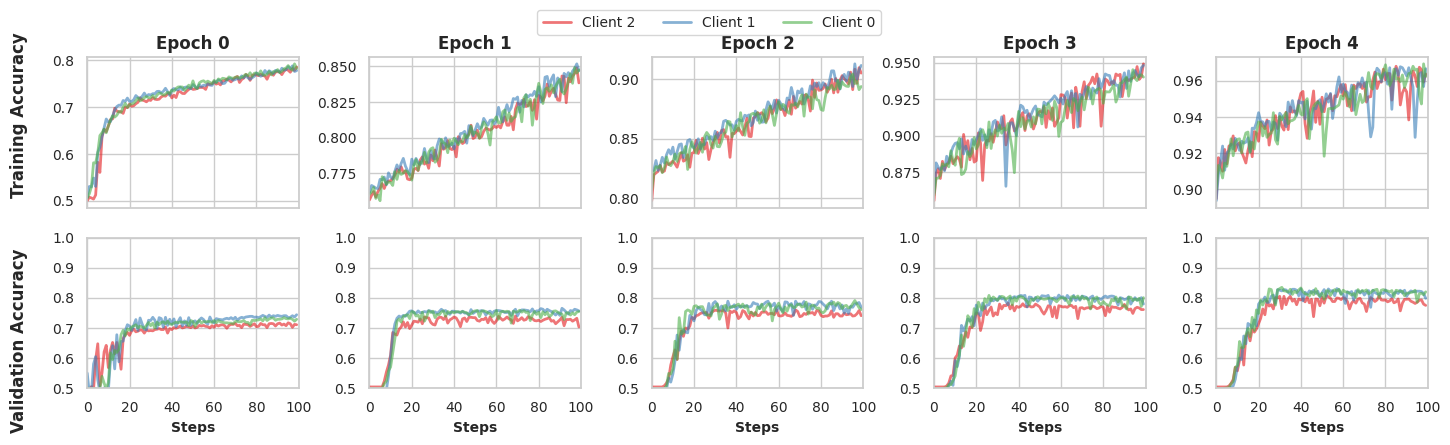

In [ ]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Initialize the API
api = wandb.Api()

# Specify the entity and project
entity = "raihanrabby"
project = "Beta_time_domain_CNN_Lstm"

# Fetch all runs from the project
runs = api.runs(f"{entity}/{project}")

# List to store the dataframes
dataframes = []

# Iterate over each run and fetch the history
for run in runs:
    # Fetch the history for each run
    history = run.history()

    # Add columns to identify the run, model name, epoch, and client
    history['run_id'] = run.id
    history['model_name'] = run.name

    # Extract epoch and client from model name
    match = re.match(r'epoch_(\d+)_client_(\d+)', run.name)
    if match:
        history['epoch_number'] = int(match.group(1))
        history['client_number'] = int(match.group(2))
    else:
        history['epoch_number'] = None
        history['client_number'] = None

    # Append to the list of dataframes
    dataframes.append(history)

# Concatenate all dataframes into a single dataframe
all_metrics_df = pd.concat(dataframes)

# Filter out rows with None epoch_number
all_metrics_df = all_metrics_df.dropna(subset=['epoch_number'])

# Get the unique epochs
unique_epochs = sorted(all_metrics_df['epoch_number'].unique())

# Set the Seaborn style
sns.set(style="whitegrid")

# Create subplots for each epoch
fig, axes = plt.subplots(2, len(unique_epochs), figsize=(len(unique_epochs) * 3, 4.5), sharex=True)

# Set the color palette
palette = sns.color_palette("Set1", n_colors=all_metrics_df['client_number'].nunique())

# Store the lines and labels for the legend
lines = []
labels = []

# Iterate through each epoch and plot the training and validation accuracy
for i, epoch in enumerate(unique_epochs):
    epoch_df = all_metrics_df[all_metrics_df['epoch_number'] == epoch]
    for j, client in enumerate(epoch_df['client_number'].unique()):
        client_df = epoch_df[epoch_df['client_number'] == client]
        line, = axes[0, i].plot(client_df['accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)
        axes[1, i].plot(client_df['val_accuracy'], label=f'Client {client}', alpha=0.6, color=palette[j], linewidth=2.0)

        if i == 0:
            lines.append(line)
            labels.append(f'Client {client}')

    axes[0, i].set_title(f'Epoch {epoch}', fontsize=12, fontweight='bold')
    axes[0, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
    axes[1, i].set_xlim(0, 100)  # Ensure x-axis covers exactly 100 steps
    # axes[0, i].set_ylim(0.5)  # Ensure y-axis covers full range of accuracy
    axes[1, i].set_ylim(0.5, 1.0)  # Ensure y-axis covers full range of accuracy
    axes[1, i].set_xlabel('Steps', fontsize=10, fontweight='bold')
    axes[0, i].grid(True)
    axes[1, i].grid(True)
    axes[0, i].tick_params(axis='both', which='major', labelsize=10)
    axes[1, i].tick_params(axis='both', which='major', labelsize=10)

# Add a single legend for the entire figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(labels), fontsize=10, frameon=True)

# Add row labels
fig.text(0.04, 0.75, 'Training Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')
fig.text(0.04, 0.25, 'Validation Accuracy', ha='center', va='center', rotation='vertical', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2, top=0.88)  # Add some space between the rows and reduce space between the legend and plot
plt.show()


In [ ]:
all_metrics_df

,_runtime,accuracy,val_loss,_timestamp,val_accuracy,loss,_step,epoch,run_id
0,13.310213,0.894723,0.860759,1.716588e+09,0.504283,0.247455,0,0,2nsbmzjb
1,22.364346,0.917493,0.848398,1.716588e+09,0.504283,0.195490,1,1,2nsbmzjb
2,33.860330,0.914814,0.825522,1.716588e+09,0.504283,0.204736,2,2,2nsbmzjb
3,43.363837,0.909992,0.825889,1.716588e+09,0.504283,0.208303,3,3,2nsbmzjb
4,44.307076,0.922047,0.801610,1.716588e+09,0.504283,0.188477,4,4,2nsbmzjb
...,...,...,...,...,...,...,...,...,...
95,416.614793,0.788910,0.553507,1.716585e+09,0.730193,0.455315,95,95,u6ki5wej
96,417.041695,0.782213,0.548009,1.716585e+09,0.732334,0.458011,96,96,u6ki5wej
97,417.444440,0.778998,0.550679,1.716585e+09,0.729122,0.459626,97,97,u6ki5wej
98,417.884801,0.792660,0.559028,1.716585e+09,0.722698,0.451855,98,98,u6ki5wej


# CNN

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(LSTM(256, return_sequences=True))
    # model.add(LSTM(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)


In [13]:
global_model_CNN, metrics_df_CNN = federated_learning(Theta_data)

Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 76ms/step - loss: 2.0116 - accuracy: 0.5232 - val_loss: 2.0026 - val_accuracy: 0.5744
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 1.9892 - accuracy: 0.5506 - val_loss: 1.9822 - val_accuracy: 0.5140
Epoch 3/100
29/29 [==============================] - 1s 48ms/step - loss: 1.9677 - accuracy: 0.5695 - val_loss: 1.9621 - val_accuracy: 0.5927
Epoch 4/100
29/29 [==============================] - 1s 35ms/step - loss: 1.9490 - accuracy: 0.5277 - val_loss: 1.9427 - val_accuracy: 0.5485
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 1.9278 - accuracy: 0.5493 - val_loss: 1.9234 - val_accuracy: 0.5172
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 1.9074 - accuracy: 0.5652 - val_loss: 1.9045 - val_accuracy: 0.5312
Epoch 7/100
29/29 [==============================] - 1s 34ms/step - loss: 1.8881 - accuracy: 0.5784 - val_loss: 1.8863 - val_accuracy: 0.6056
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 46ms/step - loss: 2.0141 - accuracy: 0.5003 - val_loss: 2.0036 - val_accuracy: 0.5068
Epoch 2/100
28/28 [==============================] - 1s 29ms/step - loss: 1.9926 - accuracy: 0.5198 - val_loss: 1.9842 - val_accuracy: 0.5475
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 1.9707 - accuracy: 0.5379 - val_loss: 1.9650 - val_accuracy: 0.5023
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 1.9521 - accuracy: 0.5215 - val_loss: 1.9462 - val_accuracy: 0.5045
Epoch 5/100
28/28 [==============================] - 0s 15ms/step - loss: 1.9343 - accuracy: 0.5453 - val_loss: 1.9279 - val_accuracy: 0.5204
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 1.9131 - accuracy: 0.5512 - val_loss: 1.9096 - val_accuracy: 0.5373
Epoch 7/100
28/28 [==============================] - 1s 24ms/step - loss: 1.8949 - accuracy: 0.5611 - val_loss: 1.8917 - val_accuracy: 0.5600
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 6s 36ms/step - loss: 2.0125 - accuracy: 0.5147 - val_loss: 2.0015 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 1.9913 - accuracy: 0.4997 - val_loss: 1.9797 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 1.9691 - accuracy: 0.5176 - val_loss: 1.9582 - val_accuracy: 0.5155
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 1.9475 - accuracy: 0.5080 - val_loss: 1.9376 - val_accuracy: 0.4835
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 1.9261 - accuracy: 0.5220 - val_loss: 1.9173 - val_accuracy: 0.4804
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 1.9058 - accuracy: 0.5266 - val_loss: 1.8971 - val_accuracy: 0.5506
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 1.8865 - accuracy: 0.5196 - val_loss: 1.8773 - val_accuracy: 0.5145
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 4s 35ms/step - loss: 1.0586 - accuracy: 0.5803 - val_loss: 1.0772 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 16ms/step - loss: 1.0487 - accuracy: 0.5946 - val_loss: 1.0720 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 1.0423 - accuracy: 0.5978 - val_loss: 1.0679 - val_accuracy: 0.4860
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 1.0352 - accuracy: 0.6032 - val_loss: 1.0635 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 0s 15ms/step - loss: 1.0307 - accuracy: 0.6040 - val_loss: 1.0599 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 1.0262 - accuracy: 0.6040 - val_loss: 1.0561 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 1.0231 - accuracy: 0.6026 - val_loss: 1.0540 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 5s 41ms/step - loss: 1.0553 - accuracy: 0.5979 - val_loss: 1.0771 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 1.0479 - accuracy: 0.5948 - val_loss: 1.0721 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 1.0422 - accuracy: 0.6095 - val_loss: 1.0683 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0371 - accuracy: 0.5996 - val_loss: 1.0643 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0323 - accuracy: 0.6050 - val_loss: 1.0603 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 1.0301 - accuracy: 0.6002 - val_loss: 1.0566 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 25ms/step - loss: 1.0238 - accuracy: 0.6078 - val_loss: 1.0532 - val_accuracy: 0.4966
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 34ms/step - loss: 1.0641 - accuracy: 0.5729 - val_loss: 1.0775 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 1.0543 - accuracy: 0.5811 - val_loss: 1.0730 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 1.0524 - accuracy: 0.5773 - val_loss: 1.0684 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 1.0447 - accuracy: 0.5814 - val_loss: 1.0636 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 1.0402 - accuracy: 0.5871 - val_loss: 1.0613 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 1.0348 - accuracy: 0.5850 - val_loss: 1.0575 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 1.0310 - accuracy: 0.5845 - val_loss: 1.0531 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 5s 35ms/step - loss: 0.8540 - accuracy: 0.6474 - val_loss: 0.9211 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8445 - accuracy: 0.6584 - val_loss: 0.9182 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8479 - accuracy: 0.6509 - val_loss: 0.9201 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8440 - accuracy: 0.6527 - val_loss: 0.9161 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.8376 - accuracy: 0.6654 - val_loss: 0.9186 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8369 - accuracy: 0.6600 - val_loss: 0.9181 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 0s 15ms/step - loss: 0.8318 - accuracy: 0.6748 - val_loss: 0.9204 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 37ms/step - loss: 0.8534 - accuracy: 0.6460 - val_loss: 0.9189 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.8459 - accuracy: 0.6565 - val_loss: 0.9175 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 0s 15ms/step - loss: 0.8427 - accuracy: 0.6570 - val_loss: 0.9175 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 23ms/step - loss: 0.8418 - accuracy: 0.6545 - val_loss: 0.9151 - val_accuracy: 0.4966
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.8457 - accuracy: 0.6471 - val_loss: 0.9150 - val_accuracy: 0.4966
Epoch 6/100
28/28 [==============================] - 0s 16ms/step - loss: 0.8432 - accuracy: 0.6582 - val_loss: 0.9202 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 0s 17ms/step - loss: 0.8352 - accuracy: 0.6636 - val_loss: 0.9184 - val_accuracy: 0.4955
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 36ms/step - loss: 0.8699 - accuracy: 0.6145 - val_loss: 0.9201 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8550 - accuracy: 0.6473 - val_loss: 0.9218 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8526 - accuracy: 0.6419 - val_loss: 0.9218 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.8496 - accuracy: 0.6419 - val_loss: 0.9218 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8503 - accuracy: 0.6372 - val_loss: 0.9255 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 0.8513 - accuracy: 0.6339 - val_loss: 0.9259 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 0.8417 - accuracy: 0.6628 - val_loss: 0.9272 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 5s 35ms/step - loss: 0.7395 - accuracy: 0.7150 - val_loss: 0.8901 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7371 - accuracy: 0.7093 - val_loss: 0.8906 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 14ms/step - loss: 0.7222 - accuracy: 0.7260 - val_loss: 0.8919 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 16ms/step - loss: 0.7167 - accuracy: 0.7368 - val_loss: 0.8925 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 0.7149 - accuracy: 0.7360 - val_loss: 0.8988 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.7113 - accuracy: 0.7355 - val_loss: 0.9020 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 23ms/step - loss: 0.7092 - accuracy: 0.7357 - val_loss: 0.8979 - val_accuracy: 0.4871
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 47ms/step - loss: 0.7525 - accuracy: 0.7100 - val_loss: 0.8854 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 0.7280 - accuracy: 0.7224 - val_loss: 0.8863 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7270 - accuracy: 0.7230 - val_loss: 0.8866 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 31ms/step - loss: 0.7214 - accuracy: 0.7405 - val_loss: 0.8866 - val_accuracy: 0.4966
Epoch 5/100
28/28 [==============================] - 0s 17ms/step - loss: 0.7160 - accuracy: 0.7425 - val_loss: 0.8912 - val_accuracy: 0.4966
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.7120 - accuracy: 0.7431 - val_loss: 0.8945 - val_accuracy: 0.4966
Epoch 7/100
28/28 [==============================] - 0s 15ms/step - loss: 0.7124 - accuracy: 0.7388 - val_loss: 0.8967 - val_accuracy: 0.4966
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 0.7380 - accuracy: 0.7132 - val_loss: 0.8917 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.7320 - accuracy: 0.7235 - val_loss: 0.8950 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.7298 - accuracy: 0.7183 - val_loss: 0.8969 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7287 - accuracy: 0.7243 - val_loss: 0.9068 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7284 - accuracy: 0.7178 - val_loss: 0.9021 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7311 - accuracy: 0.7165 - val_loss: 0.9148 - val_accuracy: 0.4855
Epoch 8/100
31/31 [==============================] - 0s 16ms/step - loss: 0.7192 - accuracy: 0.7307 - val_loss: 0.9259 - val_accuracy: 0.4855
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 4s 34ms/step - loss: 0.6619 - accuracy: 0.7597 - val_loss: 0.8966 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 0.6173 - accuracy: 0.7945 - val_loss: 0.9003 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.6145 - accuracy: 0.8001 - val_loss: 0.9033 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 14ms/step - loss: 0.6093 - accuracy: 0.8006 - val_loss: 0.9100 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 0s 16ms/step - loss: 0.6048 - accuracy: 0.8031 - val_loss: 0.9254 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.6053 - accuracy: 0.7996 - val_loss: 0.9360 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 0s 16ms/step - loss: 0.5999 - accuracy: 0.7982 - val_loss: 0.9533 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 4s 38ms/step - loss: 0.6771 - accuracy: 0.7513 - val_loss: 0.8913 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 0s 17ms/step - loss: 0.6158 - accuracy: 0.8011 - val_loss: 0.8944 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6159 - accuracy: 0.7932 - val_loss: 0.8966 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6135 - accuracy: 0.7943 - val_loss: 0.9066 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 20ms/step - loss: 0.6056 - accuracy: 0.8033 - val_loss: 0.9102 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 0s 17ms/step - loss: 0.6059 - accuracy: 0.7982 - val_loss: 0.9293 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 29ms/step - loss: 0.6005 - accuracy: 0.8036 - val_loss: 0.9255 - val_accuracy: 0.4966
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 4s 36ms/step - loss: 0.6991 - accuracy: 0.7437 - val_loss: 0.8992 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6376 - accuracy: 0.7842 - val_loss: 0.9025 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6353 - accuracy: 0.7829 - val_loss: 0.9068 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 0s 16ms/step - loss: 0.6267 - accuracy: 0.7951 - val_loss: 0.9178 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 0s 16ms/step - loss: 0.6237 - accuracy: 0.7912 - val_loss: 0.9360 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.6327 - accuracy: 0.7827 - val_loss: 0.9417 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 0.6280 - accuracy: 0.7891 - val_loss: 0.9449 - val_accuracy: 0.4855
Epoch 8/100
31/31 

In [14]:
metrics_df_CNN.round(3)

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.504,0.505,0.456,0.479,0.456,0.553,0.008
1,1,0.554,0.544,0.662,0.597,0.662,0.445,0.107
2,2,0.588,0.641,0.402,0.494,0.402,0.775,0.177
3,0,0.540,0.539,0.551,0.545,0.551,0.529,0.080
4,1,0.576,0.596,0.468,0.524,0.468,0.684,0.151
5,2,0.607,0.644,0.480,0.550,0.480,0.735,0.215
6,0,0.570,0.618,0.369,0.462,0.369,0.772,0.141
7,1,0.591,0.591,0.590,0.591,0.590,0.592,0.182
8,2,0.612,0.626,0.558,0.590,0.558,0.667,0.225
9,0,0.595,0.633,0.454,0.529,0.454,0.737,0.191


In [15]:
metrics_df_CNN.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN/Alpha_DWT_CNN.csv', index = False)

# GRU

In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, LSTM, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow_addons as tfa

class FederatedData:
    def __init__(self, data_path, num_clients, scaler_type='MinMax', test_size=0.2):
        self.data_path = data_path
        self.num_clients = num_clients
        self.scaler_type = scaler_type
        self.test_size = test_size
        self.partitions = []  # Initialize partitions attribute
        self.load_data()
        self.scale_data()
        self.create_partitions()

    def load_data(self):
        try:
            data = np.load(self.data_path, allow_pickle=True)
            self.X = np.moveaxis(data['X'], 1, 2)  # Move axis here
            self.Y = data['Y']
            self.groups = data['Group']  # Assuming 'Group' contains group identifiers
        except KeyError as e:
            raise ValueError(f"Missing expected data field: {e}")
        except FileNotFoundError as e:
            raise ValueError(f"Data file not found: {e}")

    def scale_data(self):
        # Reshape data to 2D array for scaling
        X_reshaped = self.X.reshape(-1, self.X.shape[-1])

        # Select scaler based on input
        if self.scaler_type == 'Standard':
            scaler = StandardScaler()
        elif self.scaler_type == 'MinMax':
            scaler = MinMaxScaler(feature_range=(0, 1))
        else:
            raise ValueError("Unsupported scaler type. Choose either 'Standard' or 'MinMax'.")

        # Fit and transform the data
        scaled_data_reshaped = scaler.fit_transform(X_reshaped)

        # Reshape back to original shape
        self.X = scaled_data_reshaped.reshape(self.X.shape)

    def create_partitions(self):
        gss = GroupShuffleSplit(n_splits=self.num_clients, test_size=self.test_size, random_state=42)
        for train_index, test_index in gss.split(self.X, self.Y, self.groups):
            X_train, X_test = self.X[train_index], self.X[test_index]
            Y_train, Y_test = self.Y[train_index], self.Y[test_index]
            self.partitions.append((X_train, Y_train, X_test, Y_test))
            print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    def get_training_and_validation_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        partition_X_train, partition_Y_train, partition_X_test, partition_Y_test = self.partitions[client_idx]
        X_train, X_val, Y_train, Y_val = train_test_split(partition_X_train, partition_Y_train, test_size=0.2, random_state=42)
        return X_train, X_val, Y_train, Y_val, partition_X_test, partition_Y_test

    def get_testing_data(self, client_idx):
        if client_idx < 0 or client_idx >= len(self.partitions):
            raise ValueError(f"Invalid client index. Must be between 0 and {len(self.partitions) - 1}.")

        _, _, partition_X_test, partition_Y_test = self.partitions[client_idx]
        return partition_X_test, partition_Y_test

def build_sequential_model_gru(input_shape):
    clear_session()
    model = Sequential()

    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(256, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(512, 3, strides=1, activation='relu', padding="same"))
    model.add(MaxPooling1D(2, padding="same"))
    model.add(Conv1D(filters=1024, kernel_size=3, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(256, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(512, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # opt = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=0.00009)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    return accuracy, precision, recall, f1, sensitivity, specificity, kappa

def federated_learning_gru(data_path):
    federated_data = FederatedData(data_path, num_clients=3, scaler_type='MinMax')
    federated_data.create_partitions()

    # Get the input shape from the data
    input_shape = federated_data.X.shape[1:]
    global_model = build_sequential_model_gru(input_shape)

    num_clients = 3
    local_epochs = 5
    global_optimizer = Adam(learning_rate=0.00009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    # Initialize m and v for Adam optimizer
    m = [np.zeros_like(w) for w in global_model.get_weights()]
    v = [np.zeros_like(w) for w in global_model.get_weights()]
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-7
    t = 0

    client_data = []
    for client_idx in range(num_clients):
        x_train, x_val, y_train, y_val, x_test, y_test = federated_data.get_training_and_validation_data(client_idx)
        client_data.append((x_train, x_val, y_train, y_val, x_test, y_test))

    metrics_list = []

    for epoch in range(local_epochs):
        client_models = []

        for client in range(num_clients):
            x_train, x_val, y_train, y_val, x_test, y_test = client_data[client]
            client_model = build_sequential_model_gru(input_shape)
            client_model.set_weights(global_model.get_weights())  # Initialize with global weights
            opt = Adam(learning_rate=0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            client_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

            # Set up callbacks
            run_name = f"epoch_{epoch}_client_{client}"
            checkpoint_filepath = f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN_GRU/best_model_{run_name}.h5'
            checkpoint_callback = ModelCheckpoint(
                checkpoint_filepath,
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )
            csv_logger = CSVLogger(f'/content/drive/MyDrive/EEG Signal /Epileptic seizure/Saved model/DWT/Alpha/CNN_GRU/training_log_{run_name}.csv', append=True, separator=';')

            history = client_model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), callbacks=[checkpoint_callback, csv_logger])
            client_models.append(client_model)

            print(history.history)

            # Load the best model before evaluation
            best_model = load_model(checkpoint_filepath)

            # Evaluate client model
            y_pred = (best_model.predict(x_test) > 0.5).astype("int32")
            accuracy, precision, recall, f1, sensitivity, specificity, kappa = compute_metrics(y_test, y_pred)
            metrics_list.append({
                'Client': client,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Sensitivity': sensitivity,
                'Specificity': specificity,
                'Kappa': kappa
            })

        global_weights = global_model.get_weights()
        layer_start_idx = 0
        for layer in global_model.layers:
            layer_weights = []
            layer_biases = []
            num_params = len(layer.get_weights())
            for i in range(num_clients):
                layer_params = client_models[i].get_weights()[layer_start_idx:layer_start_idx + num_params]
                if num_params > 0:
                    layer_weights.append(layer_params[0])
                if num_params > 1:
                    layer_biases.append(layer_params[1])

            if len(layer_weights) > 0:
                averaged_layer_weights = np.mean(layer_weights, axis=0)
                if averaged_layer_weights.shape == global_weights[layer_start_idx].shape:
                    global_weights[layer_start_idx] = averaged_layer_weights
                else:
                    print(f"Warning: Shape mismatch for weights at layer {layer.name}, expected {global_weights[layer_start_idx].shape} but got {averaged_layer_weights.shape}")
            if len(layer_biases) > 0:
                averaged_layer_biases = np.mean(layer_biases, axis=0)
                if averaged_layer_biases.shape == global_weights[layer_start_idx + 1].shape:
                    global_weights[layer_start_idx + 1] = averaged_layer_biases
                else:
                    print(f"Warning: Shape mismatch for biases at layer {layer.name}, expected {global_weights[layer_start_idx + 1].shape} but got {averaged_layer_biases.shape}")

            layer_start_idx += num_params

        # Apply FedOpt (Adam) update to global weights
        t += 1
        for i in range(len(global_weights)):
            g_t = global_weights[i] - global_model.get_weights()[i]  # Gradient
            m[i] = beta1 * m[i] + (1 - beta1) * g_t
            v[i] = beta2 * v[i] + (1 - beta2) * (g_t ** 2)
            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)
            global_weights[i] -= global_optimizer.learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        global_model.set_weights(global_weights)

    metrics_df = pd.DataFrame(metrics_list)
    return global_model, metrics_df

# Example usage
# data_path = 'path/to/your/data.npz'
# global_model, metrics_df = federated_learning(data_path)
# print(metrics_df)



In [17]:
global_model_gru, metrics_df_gru = federated_learning_gru(Theta_data)

Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Train shape: (4640, 52, 29), Test shape: (1194, 52, 29)
Train shape: (4418, 52, 29), Test shape: (1416, 52, 29)
Train shape: (4838, 52, 29), Test shape: (996, 52, 29)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 256)           22528     
                                                                 
 batch_normalization (Batch  (None, 52, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 256)           0         
 D)                                                              
                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 7s 58ms/step - loss: 1.8191 - accuracy: 0.5040 - val_loss: 1.8139 - val_accuracy: 0.5151
Epoch 2/100
29/29 [==============================] - 1s 17ms/step - loss: 1.8090 - accuracy: 0.5030 - val_loss: 1.8040 - val_accuracy: 0.5151
Epoch 3/100
29/29 [==============================] - 1s 19ms/step - loss: 1.7995 - accuracy: 0.4962 - val_loss: 1.7942 - val_accuracy: 0.5151
Epoch 4/100
29/29 [==============================] - 1s 21ms/step - loss: 1.7892 - accuracy: 0.5170 - val_loss: 1.7845 - val_accuracy: 0.5151
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 1.7799 - accuracy: 0.5108 - val_loss: 1.7750 - val_accuracy: 0.5506
Epoch 6/100
29/29 [==============================] - 1s 32ms/step - loss: 1.7703 - accuracy: 0.5092 - val_loss: 1.7655 - val_accuracy: 0.5700
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 1.7608 - accuracy: 0.5170 - val_loss: 1.7562 - val_accuracy: 0.4860
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 61ms/step - loss: 1.8194 - accuracy: 0.4918 - val_loss: 1.8140 - val_accuracy: 0.5045
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 1.8093 - accuracy: 0.5020 - val_loss: 1.8045 - val_accuracy: 0.5045
Epoch 3/100
28/28 [==============================] - 0s 18ms/step - loss: 1.8000 - accuracy: 0.5031 - val_loss: 1.7950 - val_accuracy: 0.5045
Epoch 4/100
28/28 [==============================] - 1s 18ms/step - loss: 1.7910 - accuracy: 0.4994 - val_loss: 1.7856 - val_accuracy: 0.5045
Epoch 5/100
28/28 [==============================] - 0s 18ms/step - loss: 1.7813 - accuracy: 0.4975 - val_loss: 1.7764 - val_accuracy: 0.5045
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 1.7722 - accuracy: 0.5076 - val_loss: 1.7673 - val_accuracy: 0.5045
Epoch 7/100
28/28 [==============================] - 1s 21ms/step - loss: 1.7627 - accuracy: 0.5187 - val_loss: 1.7582 - val_accuracy: 0.5045
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 8s 54ms/step - loss: 1.8188 - accuracy: 0.5039 - val_loss: 1.8130 - val_accuracy: 0.5145
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 1.8083 - accuracy: 0.5049 - val_loss: 1.8023 - val_accuracy: 0.5145
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 1.7973 - accuracy: 0.5036 - val_loss: 1.7918 - val_accuracy: 0.5548
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 1.7869 - accuracy: 0.5005 - val_loss: 1.7814 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 1.7766 - accuracy: 0.5008 - val_loss: 1.7710 - val_accuracy: 0.5847
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 1.7666 - accuracy: 0.4982 - val_loss: 1.7607 - val_accuracy: 0.5145
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 1.7559 - accuracy: 0.5067 - val_loss: 1.7507 - val_accuracy: 0.5145
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 54ms/step - loss: 1.1611 - accuracy: 0.5870 - val_loss: 1.1749 - val_accuracy: 0.5851
Epoch 2/100
29/29 [==============================] - 1s 26ms/step - loss: 1.1544 - accuracy: 0.5865 - val_loss: 1.1700 - val_accuracy: 0.6067
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 1.1493 - accuracy: 0.5881 - val_loss: 1.1651 - val_accuracy: 0.5819
Epoch 4/100
29/29 [==============================] - 1s 25ms/step - loss: 1.1447 - accuracy: 0.5884 - val_loss: 1.1605 - val_accuracy: 0.6218
Epoch 5/100
29/29 [==============================] - 0s 17ms/step - loss: 1.1377 - accuracy: 0.5983 - val_loss: 1.1562 - val_accuracy: 0.5399
Epoch 6/100
29/29 [==============================] - 0s 17ms/step - loss: 1.1330 - accuracy: 0.5967 - val_loss: 1.1513 - val_accuracy: 0.5647
Epoch 7/100
29/29 [==============================] - 1s 18ms/step - loss: 1.1271 - accuracy: 0.5900 - val_loss: 1.1462 - val_accuracy: 0.5970
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 7s 76ms/step - loss: 1.1612 - accuracy: 0.5849 - val_loss: 1.1754 - val_accuracy: 0.5871
Epoch 2/100
28/28 [==============================] - 1s 22ms/step - loss: 1.1552 - accuracy: 0.5883 - val_loss: 1.1707 - val_accuracy: 0.5814
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 1.1491 - accuracy: 0.5914 - val_loss: 1.1661 - val_accuracy: 0.5826
Epoch 4/100
28/28 [==============================] - 1s 20ms/step - loss: 1.1453 - accuracy: 0.5914 - val_loss: 1.1618 - val_accuracy: 0.5124
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 1.1400 - accuracy: 0.5846 - val_loss: 1.1573 - val_accuracy: 0.5283
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 1.1410 - accuracy: 0.5764 - val_loss: 1.1530 - val_accuracy: 0.5147
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 1.1302 - accuracy: 0.5965 - val_loss: 1.1482 - val_accuracy: 0.5860
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 72ms/step - loss: 1.1677 - accuracy: 0.5685 - val_loss: 1.1750 - val_accuracy: 0.5682
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 1.1604 - accuracy: 0.5788 - val_loss: 1.1699 - val_accuracy: 0.5795
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 1.1561 - accuracy: 0.5685 - val_loss: 1.1648 - val_accuracy: 0.5682
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 1.1499 - accuracy: 0.5729 - val_loss: 1.1605 - val_accuracy: 0.5031
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 1.1453 - accuracy: 0.5736 - val_loss: 1.1555 - val_accuracy: 0.5145
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 1.1400 - accuracy: 0.5682 - val_loss: 1.1506 - val_accuracy: 0.5186
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 1.1351 - accuracy: 0.5801 - val_loss: 1.1455 - val_accuracy: 0.5465
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 57ms/step - loss: 0.8897 - accuracy: 0.6150 - val_loss: 0.9229 - val_accuracy: 0.5032
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.8864 - accuracy: 0.6166 - val_loss: 0.9213 - val_accuracy: 0.4914
Epoch 3/100
29/29 [==============================] - 1s 20ms/step - loss: 0.8828 - accuracy: 0.6172 - val_loss: 0.9197 - val_accuracy: 0.4871
Epoch 4/100
29/29 [==============================] - 1s 19ms/step - loss: 0.8835 - accuracy: 0.6118 - val_loss: 0.9187 - val_accuracy: 0.4828
Epoch 5/100
29/29 [==============================] - 1s 20ms/step - loss: 0.8833 - accuracy: 0.6080 - val_loss: 0.9186 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 19ms/step - loss: 0.8790 - accuracy: 0.6102 - val_loss: 0.9151 - val_accuracy: 0.4860
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.8768 - accuracy: 0.6153 - val_loss: 0.9138 - val_accuracy: 0.4828
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 9s 77ms/step - loss: 0.8933 - accuracy: 0.6095 - val_loss: 0.9234 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 36ms/step - loss: 0.8871 - accuracy: 0.6132 - val_loss: 0.9216 - val_accuracy: 0.5090
Epoch 3/100
28/28 [==============================] - 1s 28ms/step - loss: 0.8833 - accuracy: 0.6183 - val_loss: 0.9197 - val_accuracy: 0.5136
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.8848 - accuracy: 0.6160 - val_loss: 0.9188 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 27ms/step - loss: 0.8855 - accuracy: 0.6146 - val_loss: 0.9159 - val_accuracy: 0.5498
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.8809 - accuracy: 0.6146 - val_loss: 0.9150 - val_accuracy: 0.5045
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.8783 - accuracy: 0.6188 - val_loss: 0.9141 - val_accuracy: 0.4943
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 61ms/step - loss: 0.9006 - accuracy: 0.5917 - val_loss: 0.9237 - val_accuracy: 0.4866
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.8958 - accuracy: 0.5992 - val_loss: 0.9218 - val_accuracy: 0.4824
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 0.8914 - accuracy: 0.6044 - val_loss: 0.9202 - val_accuracy: 0.4866
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 0.8891 - accuracy: 0.6052 - val_loss: 0.9188 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 22ms/step - loss: 0.8879 - accuracy: 0.6039 - val_loss: 0.9163 - val_accuracy: 0.4835
Epoch 6/100
31/31 [==============================] - 1s 21ms/step - loss: 0.8857 - accuracy: 0.6041 - val_loss: 0.9148 - val_accuracy: 0.4824
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.8855 - accuracy: 0.6005 - val_loss: 0.9137 - val_accuracy: 0.4824
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 6s 56ms/step - loss: 0.7773 - accuracy: 0.6492 - val_loss: 0.8467 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.7726 - accuracy: 0.6592 - val_loss: 0.8464 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 18ms/step - loss: 0.7655 - accuracy: 0.6689 - val_loss: 0.8468 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 0s 17ms/step - loss: 0.7612 - accuracy: 0.6705 - val_loss: 0.8463 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 25ms/step - loss: 0.7611 - accuracy: 0.6713 - val_loss: 0.8446 - val_accuracy: 0.4860
Epoch 6/100
29/29 [==============================] - 1s 27ms/step - loss: 0.7584 - accuracy: 0.6727 - val_loss: 0.8447 - val_accuracy: 0.4871
Epoch 7/100
29/29 [==============================] - 1s 20ms/step - loss: 0.7589 - accuracy: 0.6778 - val_loss: 0.8440 - val_accuracy: 0.4860
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 8s 61ms/step - loss: 0.7727 - accuracy: 0.6619 - val_loss: 0.8461 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7660 - accuracy: 0.6647 - val_loss: 0.8450 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.7655 - accuracy: 0.6692 - val_loss: 0.8460 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7645 - accuracy: 0.6655 - val_loss: 0.8456 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7674 - accuracy: 0.6619 - val_loss: 0.8454 - val_accuracy: 0.4943
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.7578 - accuracy: 0.6740 - val_loss: 0.8448 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 18ms/step - loss: 0.7619 - accuracy: 0.6644 - val_loss: 0.8444 - val_accuracy: 0.4921
Epoch 8/100
28/28 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 57ms/step - loss: 0.7824 - accuracy: 0.6468 - val_loss: 0.8467 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.7864 - accuracy: 0.6354 - val_loss: 0.8473 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7738 - accuracy: 0.6556 - val_loss: 0.8481 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7697 - accuracy: 0.6602 - val_loss: 0.8481 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 0.7690 - accuracy: 0.6599 - val_loss: 0.8513 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.7728 - accuracy: 0.6506 - val_loss: 0.8510 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.7619 - accuracy: 0.6682 - val_loss: 0.8535 - val_accuracy: 0.4855
Epoch 8/100
31/31 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 8s 57ms/step - loss: 0.7044 - accuracy: 0.7015 - val_loss: 0.8329 - val_accuracy: 0.4849
Epoch 2/100
29/29 [==============================] - 1s 18ms/step - loss: 0.6871 - accuracy: 0.7198 - val_loss: 0.8339 - val_accuracy: 0.4849
Epoch 3/100
29/29 [==============================] - 1s 17ms/step - loss: 0.6879 - accuracy: 0.7182 - val_loss: 0.8339 - val_accuracy: 0.4849
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.6759 - accuracy: 0.7284 - val_loss: 0.8379 - val_accuracy: 0.4849
Epoch 5/100
29/29 [==============================] - 1s 18ms/step - loss: 0.6746 - accuracy: 0.7325 - val_loss: 0.8462 - val_accuracy: 0.4849
Epoch 6/100
29/29 [==============================] - 1s 18ms/step - loss: 0.6750 - accuracy: 0.7301 - val_loss: 0.8476 - val_accuracy: 0.4849
Epoch 7/100
29/29 [==============================] - 1s 17ms/step - loss: 0.6770 - accuracy: 0.7236 - val_loss: 0.8507 - val_accuracy: 0.4849
Epoch 8/100
29/29 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 10s 64ms/step - loss: 0.7015 - accuracy: 0.7066 - val_loss: 0.8286 - val_accuracy: 0.4955
Epoch 2/100
28/28 [==============================] - 1s 18ms/step - loss: 0.7007 - accuracy: 0.7074 - val_loss: 0.8317 - val_accuracy: 0.4955
Epoch 3/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6763 - accuracy: 0.7278 - val_loss: 0.8325 - val_accuracy: 0.4955
Epoch 4/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6762 - accuracy: 0.7281 - val_loss: 0.8396 - val_accuracy: 0.4955
Epoch 5/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6701 - accuracy: 0.7233 - val_loss: 0.8426 - val_accuracy: 0.4955
Epoch 6/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6756 - accuracy: 0.7241 - val_loss: 0.8477 - val_accuracy: 0.4955
Epoch 7/100
28/28 [==============================] - 1s 19ms/step - loss: 0.6668 - accuracy: 0.7431 - val_loss: 0.8493 - val_accuracy: 0.4955
Epoch 8/100
28/28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 7s 57ms/step - loss: 0.7269 - accuracy: 0.6801 - val_loss: 0.8326 - val_accuracy: 0.4855
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6895 - accuracy: 0.7124 - val_loss: 0.8364 - val_accuracy: 0.4855
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.6887 - accuracy: 0.7145 - val_loss: 0.8385 - val_accuracy: 0.4855
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6837 - accuracy: 0.7214 - val_loss: 0.8420 - val_accuracy: 0.4855
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 0.6824 - accuracy: 0.7207 - val_loss: 0.8525 - val_accuracy: 0.4855
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6777 - accuracy: 0.7258 - val_loss: 0.8645 - val_accuracy: 0.4855
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 0.6752 - accuracy: 0.7258 - val_loss: 0.8777 - val_accuracy: 0.4855
Epoch 8/100
31/31 

In [18]:
metrics_df_gru

,Client,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Kappa
0,0,0.526801,0.526756,0.527638,0.527197,0.527638,0.525963,0.053601
1,1,0.571328,0.556805,0.699153,0.619912,0.699153,0.443503,0.142655
2,2,0.605422,0.615385,0.562249,0.587618,0.562249,0.648594,0.210843
3,0,0.553601,0.549689,0.592965,0.570508,0.592965,0.514238,0.107203
4,1,0.567797,0.571006,0.545198,0.557803,0.545198,0.590395,0.135593
5,2,0.610442,0.638889,0.508032,0.565996,0.508032,0.712851,0.220884
6,0,0.557789,0.565714,0.497487,0.529412,0.497487,0.618090,0.115578
7,1,0.579802,0.575033,0.611582,0.592745,0.611582,0.548023,0.159605
8,2,0.614458,0.699301,0.401606,0.510204,0.401606,0.827309,0.228916
9,0,0.567839,0.587097,0.457286,0.514124,0.457286,0.678392,0.135678


In [19]:
metrics_df_gru.round(4).to_csv('/content/drive/MyDrive/EEG Signal /results/FLresults/DWT/CNN_GRU/Alpha_DWT_GRU.csv', index = False)

In [20]:
print('hello')

hello
